In [1]:
import pandas as pd
import csv
import numpy as np
import re
import string as string_library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from nltk.stem.porter import PorterStemmer
import math
import warnings
import random
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

# Build the training set and then Classify

In [2]:
videos = []
with open("sentence_clusters_fastcluster_nonbinary_all.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        videos.append([row[0], row[1], row[2], row[3], row[4]])
        
videos_en_new = pd.DataFrame(videos, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum'])
del videos

In [3]:
num_coupon_codes = 0
for i, row in videos_en_new.iterrows():
    if row['clusterNum'] == str(68):
        num_coupon_codes += 1
        videos_en_new.at[i, 'isCoupon'] = 1
    else:
        videos_en_new.at[i, 'isCoupon'] = 0

In [4]:
print videos_en_new.shape

(77706, 6)


In [5]:
print num_coupon_codes

177


In [6]:
# There are few coupon codes compared to the size of the dataset
# Need to shrink the negative sample size in our training dataset
sample_set = videos_en_new.sample(n=1000)

In [7]:
sample_set.shape

(1000, 6)

In [8]:
positives = []
for i, row in videos_en_new.iterrows():
    if row['isCoupon'] == 1:
        positives.append([row.id, row.description, row.channelTitle, row.sentence, row.clusterNum, row.isCoupon])
        
positiveDF = pd.DataFrame(positives, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum', 'isCoupon'])
del positives
print(positiveDF.shape)

(177, 6)


In [9]:
training_set = sample_set.append(positiveDF, ignore_index=True)
training_set.shape

(1177, 6)

In [10]:
y = training_set.isCoupon

In [11]:
#stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string_library.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string_library.punctuation) for f in tokens]
    for i in range(len(tokens_)):
        if tokens_[i][0:2] == "b'":
            tokens_[i] = tokens[i][2:]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    #tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_


In [12]:
print "[",
for word in nltk.corpus.stopwords.words('english'):
    print "\"" + word+ "\"", ",",

[ "i" , "me" , "my" , "myself" , "we" , "our" , "ours" , "ourselves" , "you" , "you're" , "you've" , "you'll" , "you'd" , "your" , "yours" , "yourself" , "yourselves" , "he" , "him" , "his" , "himself" , "she" , "she's" , "her" , "hers" , "herself" , "it" , "it's" , "its" , "itself" , "they" , "them" , "their" , "theirs" , "themselves" , "what" , "which" , "who" , "whom" , "this" , "that" , "that'll" , "these" , "those" , "am" , "is" , "are" , "was" , "were" , "be" , "been" , "being" , "have" , "has" , "had" , "having" , "do" , "does" , "did" , "doing" , "a" , "an" , "the" , "and" , "but" , "if" , "or" , "because" , "as" , "until" , "while" , "of" , "at" , "by" , "for" , "with" , "about" , "against" , "between" , "into" , "through" , "during" , "before" , "after" , "above" , "below" , "to" , "from" , "up" , "down" , "in" , "out" , "on" , "off" , "over" , "under" , "again" , "further" , "then" , "once" , "here" , "there" , "when" , "where" , "why" , "how" , "all" , "any" , "both" , "eac

In [13]:
countVec = CountVectorizer(tokenizer=tokenize, min_df=4).fit(training_set['sentence'])

In [14]:
len(countVec.get_feature_names())

245

In [15]:
params = {'C': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.2, 1.5, 2, 5, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 5, 10, 20, 50]}
clf = GridSearchCV(SVC(probability=True), params, cv=5)

Round 1
Best Params:  {'kernel': 'linear', 'C': 0.5, 'degree': 2}
Best Score:  0.9987244897959183
AUC Cross-validated scores: [1.        0.9993985 1.        1.        1.       ]
r2 score:  0.9393206381883685
F1 Score:  0.9739130434782608
Confusion matrix: 
[[334   1]
 [  2  56]]


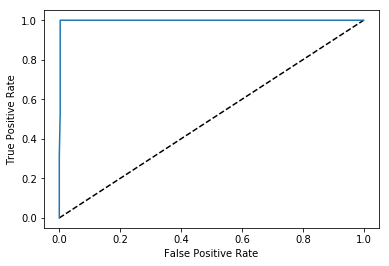

_______________________________________________________________
Round 2
Best Params:  {'kernel': 'linear', 'C': 0.8, 'degree': 2}
Best Score:  0.9949044585987261
AUC Cross-validated scores: [1.         1.         1.         0.99984336 1.        ]
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[333   0]
 [  0  59]]


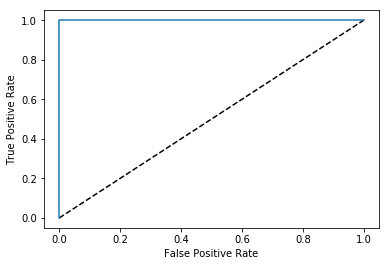

_______________________________________________________________
Round 3
Best Params:  {'kernel': 'linear', 'C': 1.5, 'degree': 2}
Best Score:  0.9987261146496815
AUC Cross-validated scores: [1.         1.         1.         0.99852893 1.        ]
r2 score:  0.9810874704491725
F1 Score:  0.9921259842519685
Confusion matrix: 
[[328   1]
 [  0  63]]


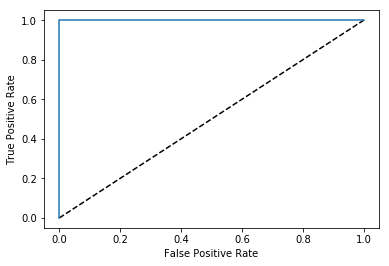

_______________________________________________________________


In [16]:
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(training_set)
round_num = 0
for train_index, test_index in kf.split(training_set):
    round_num += 1
    print 'Round', round_num
    X_train, X_test = training_set.loc[train_index], training_set.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    lineVec = countVec.transform(X_train['sentence'])
    testVec = countVec.transform(X_test['sentence'])
    clf.fit(lineVec, X_train['isCoupon'])
    predictions = clf.predict(testVec)
    print "Best Params: ", clf.best_params_
    print "Best Score: ", clf.best_score_
    print 'AUC Cross-validated scores:', cross_val_score(clf, lineVec, y_train, cv=5, scoring='roc_auc')
    print 'r2 score: ', metrics.r2_score(y_test, predictions)
    print 'F1 Score: ', metrics.f1_score(y_test, predictions)
    print 'Confusion matrix: '
    print metrics.confusion_matrix(y_test, predictions)
    predicted_probabilites = clf.predict_proba(testVec)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print '_______________________________________________________________'

# Check How the weights will work in the Browser Extension

In [17]:
classifier = SVC(kernel='linear', C=1, degree=2)
lineVec = countVec.transform(training_set['sentence'])
classifier.fit(lineVec, training_set['isCoupon'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [18]:
features = countVec.get_feature_names()
weights = classifier.coef_.toarray()[0]
for i in range(len(weights)):
    if weights[i] > 0:
        print "%1.5f" % weights[i], "\t", features[i]

1.99992 	checkout
1.99942 	code
1.56506 	codes
0.00042 	coupon
0.43470 	discount
0.00047 	products
0.43478 	psn
0.00006 	save


In [19]:
features = countVec.get_feature_names()

def get_vector(sentence):
    vector = [0] * len(features)
    tokens = tokenize(sentence)
    for token in tokens:
        if token in features:
            vector[features.index(token)] += 1
    return vector

In [20]:
false_positives = 0
false_negatives = 0
for i, row in videos_en_new.iterrows():
    tot = 0
    vector = get_vector(row['sentence'])
    for j in range(len(weights)):
        tot += weights[j] * vector[j]
    if tot > 1:
        if row['isCoupon'] == 0:
            #print "False +: ", row['sentence']
            false_positives += 1
    else:
        if row['isCoupon'] == 1:
            false_negatives += 1
            #print "False -: ", row['sentence']

In [21]:
total_vids = videos_en_new.shape[0]
print "Total Inputs: ", total_vids
print "False Positives: ", false_positives # some of these are coupon codes
print "False Positive Percentage: %1.2f" % (false_positives/(total_vids*1.0) * 100), "%"
print "False Negatives: ", false_negatives # could be a result of imperfections in the cluster

Total Inputs:  77706
False Positives:  117
False Positive Percentage: 0.15 %
False Negatives:  0


# Export features and Weights

In [22]:
features = countVec.get_feature_names()
non_zero_features = []
print len(features), len(weights)
num_zeroes = 0
weights_string = "const CouponWeights = ["
for i in range(len(weights)):
    item = weights[i]
    if item == 0:
        num_zeroes += 1
    else:
        non_zero_features.append(features[i])
        weights_string += '%1.20f' % item + ", "
weights_string = weights_string[0:-2] + "];"

features_string = "const CouponFeatures = ["
for item in non_zero_features:
    temp = item
    features_string += '"' + temp + '",'
features_string = features_string[0:-1] + "];"

print weights_string
print features_string
print len(non_zero_features), len(weights)-num_zeroes

245 245
const CouponWeights = [-0.00012450592212507713, -0.00015106737564107853, -0.00031359848219128170, -0.00012450592212507713, -0.00007982301128326309, -0.00007982301128326309, -0.00002557933460532871, -0.52193298172818680669, 1.99991793412003149299, -0.00046393724313512075, -0.00027081629850073141, 1.99942120278743118433, 1.56506175212848153144, -0.00004803490949437019, -0.00030643870188213837, 0.00041955039420813346, 0.43470431077497950767, -0.00016866282584093246, -0.52193298172818680669, -0.00004331641018606724, -0.00008206587996827986, -0.00014922487184815258, -0.00007982301128326309, -0.00027081629850073141, -0.00014922487184815258, -0.00014062283652711382, -0.00016114660182036528, -0.00028416784943504627, -0.52193298172818680669, -0.00041814862151268043, 0.00046959236249419711, 0.43478230302227971471, 0.00006108494730403647, -0.00014922487184815258, -0.00002557933460532871, -0.00004673840755380543, -0.00008252130132337674, -0.00044159565259323935, -0.00012450592212507713, -1

Round 1
Best Params:  {'kernel': 'linear', 'C': 1.2, 'degree': 2}
Best Score:  0.9990348235657478
r2 score:  0.6240711355368063
F1 Score:  0.8095238095238094
Confusion matrix: 
[[25827    11]
 [   13    51]]


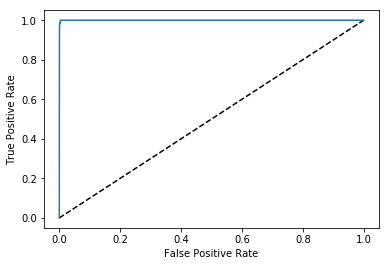

_______________________________________________________________
Round 2


In [ ]:
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(videos_en_new)
round_num = 0
for train_index, test_index in kf.split(videos_en_new):
    round_num += 1
    print 'Round', round_num
    X_train, X_test = videos_en_new.loc[train_index], videos_en_new.loc[test_index]
    y = videos_en_new.isCoupon
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    lineVec = countVec.transform(X_train['sentence'])
    testVec = countVec.transform(X_test['sentence'])
    clf.fit(lineVec, X_train['isCoupon'])
    predictions = clf.predict(testVec)
    print "Best Params: ", clf.best_params_
    print "Best Score: ", clf.best_score_
    #print 'AUC Cross-validated scores:', cross_val_score(clf, lineVec, y_train, cv=5, scoring='roc_auc')
    print 'r2 score: ', metrics.r2_score(y_test, predictions)
    print 'F1 Score: ', metrics.f1_score(y_test, predictions)
    print 'Confusion matrix: '
    print metrics.confusion_matrix(y_test, predictions)
    predicted_probabilites = clf.predict_proba(testVec)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print '_______________________________________________________________'